In [1]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
from libs.simulation_tools import *
from qiskit_aer import AerSimulator
from libs.satellite import *

In [2]:
# satellite_1293 = LEOsatellite(
#     libs_dir + '/data/STARLINK_1293.txt')
# location = np.loadtxt(
#     libs_dir + '/data/ogs_loc.txt')
# year = 2021
# day = 357
# hour = 16
# minute = 29
# t = np.arange(0, 241, 10)
# second = 53 + t
# utc = 9
# latitude = location[:, 0]
# longitude = location[:, 1]
# elevation = location[:, 2]

# slant_path_lst = np.zeros(len(second))
# zenith_angle_lst = np.zeros(len(second))
# for idx in range(len(second)):
#     slant_path_lst[idx], zenith_angle_lst[idx] = satellite_1293.computeGeometricWithUser(
#         year, day, hour, minute, second[idx], utc,
#         longitude[idx], latitude[idx], elevation[idx]
#     )

# slant_path_lst = slant_path_lst * 1000

In [18]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# Bob用のリスト
# Location: Sendai
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# Alice用のリスト
# Location: Aizuwakamatsu
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

print(f'zenith_angle_bob_lst: {zenith_angle_bob_lst}')
print(f'zenith_angle_alice_lst: {zenith_angle_alice_lst}')

zenith_angle_bob_lst: [59.12231128 56.36761957 53.29942595 49.86960124 46.02580343 41.71462467
 36.88795594 31.51443373 25.59889386 19.2177631  12.61487602  6.7674352
  6.48171328 12.17404931 18.77234156 25.17778075 31.12682233 36.53619297
 41.39769812 45.74103304 49.61362622 53.06877427 56.15900865 58.93278366
 61.43314946]
zenith_angle_alice_lst: [59.82718274 57.2108359  54.32061774 51.12265988 47.58502771 43.68407524
 39.41624395 34.81936318 30.01091959 25.25726193 21.09107561 18.42093337
 18.23006705 20.60552853 24.62583646 29.3362728  34.15602207 38.79012613
 43.10561986 47.05648663 50.64212895 53.88427991 56.81419115 59.46569665
 61.87164758]


In [19]:
num_channel_coefficients = 10000 #100000
num_qubits_per_channel_coefficient = int(1e6)

tau_zen_lst = np.array([0.81, 0.55])
# tau_zen_lst = np.array([0.81])

In [20]:
backend = AerSimulator()

qber_simul =  np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [ ]:
# 修正後のコード
# 前提：slant_path_user_lst と slant_path_repeater_lst も同様に用意されていると仮定します。

for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    print(tau_zen)
    # 時間ステップ（jdx）でループ。リストの長さはアリスとボブで同じはずです。
    for jdx in range(len(zenith_angle_alice_lst)):
        # --- 各時間ステップで、アリスとボブのパラメータをそれぞれ設定 ---
        # アリス（alice）のパラメータ
        zenith_angle_alice_deg = zenith_angle_alice_lst[jdx]
        zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
        print(zenith_angle_alice_deg)
        slant_path_alice = slant_path_alice_lst[jdx] # アリスの距離
        sigma_R_squared_alice = rytov_variance(
            wavelength, zenith_angle_alice_rad, h_OGS, h_atm, Cn2_profile)
        w_L_alice = slant_path_alice * theta_rad
        w_Leq_squared_alice = equivalent_beam_width_squared(a, w_L_alice)

        # ボブ（Repeater）のパラメータ
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        slant_path_bob = slant_path_bob_lst[jdx] # ボブの距離
        sigma_R_squared_bob = rytov_variance(
            wavelength, zenith_angle_bob_rad, h_OGS, h_atm, Cn2_profile)
        w_L_bob = slant_path_bob * theta_rad
        w_Leq_squared_bob = equivalent_beam_width_squared(a, w_L_bob)
        
        # --- 統計的な平均を取るためのループ ---
        total_err_num = 0
        total_sifted_bit_length = 0

        for kdx in range(int(num_channel_coefficients)):
            # --- ステップ1: アリスとボブの瞬時チャネル状態をそれぞれ計算 ---

            # アリス(User)の瞬時チャネル
            eta_ell_alice = compute_atm_loss(tau_zen, zenith_angle_alice_rad)
            eta_p_alice = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_path_alice, theta_rad, a, w_Leq_squared_alice, size=1
            )
            I_a_alice = rvs_LN_fading(sigma_R_squared_alice, size=1)
            insta_eta_alice = eta_ell_alice * I_a_alice * eta_p_alice
            
            insta_qber_alice = qber_loss(
                e_0, p_dark, e_pol, p_AP, insta_eta_alice, n_s
            )[0]
            # アリスの個別のYieldを計算
            insta_yield_alice = compute_yield(
                insta_eta_alice, n_s, p_dark, p_AP
            )[0]

            # ボブ(Repeater)の瞬時チャネル
            eta_ell_bob = compute_atm_loss(tau_zen, zenith_angle_bob_rad)
            eta_p_bob = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_path_bob, theta_rad, a, w_Leq_squared_bob, size=1
            )
            I_a_bob = rvs_LN_fading(sigma_R_squared_bob, size=1)
            insta_eta_bob = eta_ell_bob * I_a_bob * eta_p_bob
            
            insta_qber_bob = qber_loss(
                e_0, p_dark, e_pol, p_AP, insta_eta_bob, n_s
            )[0]
            # ボブの個別のYieldを計算
            insta_yield_bob = compute_yield(
                insta_eta_bob, n_s, p_dark, p_AP
            )[0]

            # --- ステップ2: 同時検出確率を計算 ---
            
            insta_yield_joint = insta_yield_alice * insta_yield_bob

            # --- ステップ3: ふるい分け鍵の長さを決定 ---
            # この計算方法は統計的に正しく、効率的です
            num_detected_event = np.count_nonzero(
                np.random.choice([1, 0], 
                                 p=[insta_yield_joint, 1 - insta_yield_joint], 
                                 size=num_qubits_per_channel_coefficient)
            )
            
            
            print(num_detected_event)
            # --- ステップ4: エラーをシミュレートし、鍵を生成 ---
            
            if (num_detected_event % 2 != 0):
                num_detected_event  = num_detected_event - 1
            
            # 検出イベントがなければ、この回の試行は終了
            if (num_detected_event == 0):
                continue
            
            # generate_Siftedkeyに渡す引数は正しい
            part_ka, part_kb, err_num = generate_Siftedkey(
                num_detected_event, insta_qber_alice, insta_qber_bob, backend
            )
            
            total_err_num += err_num
            total_sifted_bit_length += len(part_ka)
        
        # ゼロ割を避ける
        if total_sifted_bit_length == 0:
            avg_qber = float('nan') # または 0 や 1 など、状況に応じて設定
        else:
            avg_qber = total_err_num / total_sifted_bit_length
            
        print(f'QBER: {avg_qber} at Alice ZD {zenith_angle_alice_deg:.2f} deg, Bob ZD {zenith_angle_bob_deg:.2f} deg')
        # qber_simulのインデックスを要確認
        qber_simul[idx][jdx] = avg_qber

0.81
59.82718273636165
4
21
25
6
39
25
112
1
11
117
17
7
36
53
204
95
49
38
20
2
15
1
8
13
17
4
11
40
29
17
1
9
472
153
8
74
3
141
4
9
7
12
2
38
6
9
10
147
2
53
13
13
144
5
5
56
30
4
11
26
4
5
47
9
9
39
29
21
30
61
51
9
8
23
93
57
28
3
67
75
7
33
35
14
27
21
11
12
18
47
25
25
101
3
8
81
2
21
16
33
7
144
34
10
6
134
12
7
6
14
20
8
19
31
76
17
0
58
21
22
46
152
11
19
68
35
58
68
41
1
2
29
22
6
13
8
6
23
19
30
40
1
6
13
2
4
29
36
6
18
27
30
264
5
10
51
12
13
45
8
39
47
44
30
4
9
11
6
31
14
10
5
7
52
31
2
19
23
11
3
22
19
6
7
1
165
30
7
67
23
5
7
45
3
9
18
2
311
47
17
273
27
4
13
12
13
85
25
136
139
3
18
11
18
4
19
151
3
5
79
3
21
6
19
35
36
17
11
32
5
15
11
49
1
5
1
36
20
24
23
64
2
7
13
8
33
24
3
60
16
29
22
17
56
29
188
6
2
3
9
2
61
32
6
34
86
12
10
15
37
17
51
20
14
70
38
1
34
42
412
24
19
12
361
41
16
12
1
22
15
106
93
16
24
29
9
79
5
4
69
217
8
66
76
10
11
70
11
42
11
6
5
7
13
3
37
23
22
4
2
52
14
8
81
19
34
4
178
34
9
81
6
34
75
25
6
17
7
0
44
16
11
37
55
1
7
1
4
85
46
28
8
15
1
39


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

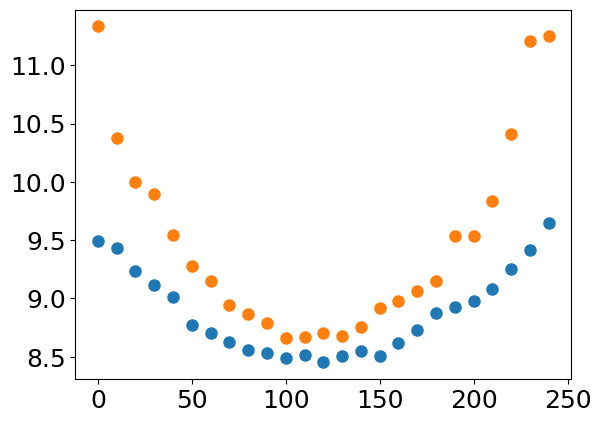

In [11]:
plt.scatter(t, qber_simul[0][:]*100)
plt.scatter(t, qber_simul[1][:]*100)


In [12]:
np.save('results/qber_simul_bbm92_test1_8', qber_simul)

In [13]:
skr_values =  np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [16]:
# for idx in range(len(tau_zen_lst)):
#     tau_zen = tau_zen_lst[idx]
#     for jdx in range(len(zenith_angle_alice_lst)):
#         zenith_angle_deg = zenith_angle_lst[jdx]
#         zenith_angle_rad = np.radians(zenith_angle_deg)
        
#         w_L = slant_path_lst[jdx] * theta_rad

#         _, yield_values= compute_avg_qber(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )
        

#         Q_1, e_1 = compute_Q_1_e_1_ex(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )

#         skr_values[idx][jdx] = compute_SKR(
#             qber_simul[idx][jdx], yield_values, Q_1, e_1
#         )
qber_simul = np.load('results/qber_simul_bbm92_test1_8.npy')
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        
        # --- アリスとボブの平均チャネル性能を計算 ---
        # w_Lをそれぞれ計算
        w_L_alice = slant_path_alice_lst[jdx] * theta_rad
        w_L_bob = slant_path_bob_lst[jdx] * theta_rad

        # アリスの性能
        _, yield_alice = compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_alice_lst[jdx], mu_x, mu_y,
            np.radians(zenith_angle_alice_lst[jdx]), h_OGS, h_atm, w_L_alice, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )
        
        # ボブの性能
        _, yield_bob = compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_bob_lst[jdx], mu_x, mu_y,
            np.radians(zenith_angle_bob_lst[jdx]), h_OGS, h_atm, w_L_bob, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )
        yield_system = yield_alice * yield_bob
        
        skr_values[idx][jdx] = compute_SKR_final(
            qber_system=qber_simul[idx][jdx], # 計算したシステムQBER
            yield_alice=yield_alice,         # 計算したアリスのYield
            yield_bob=yield_bob,           # 計算したボブのYield
            f_ec=1.0,
            rep_rate=1e9
        )

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

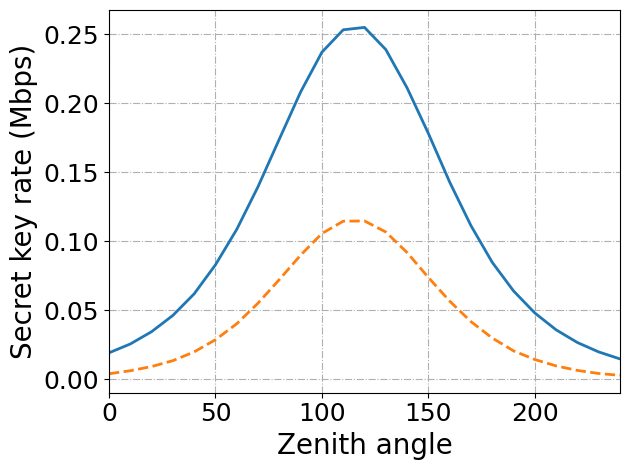

In [17]:
plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')


plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()

In [9]:
np.save('results/skr_simul_bbm92_test1', skr_values)